# Grad-CAM

This can be used to check where the model looks at in the image. Run the notebook, make sure to load the correct model that you are interested in and to have an image of interest ready. 
For simplicity, save the image in this working directory for the limited time of running the notebook. 


## Utility functions

In [1]:
from functools import wraps 

# function to add class methods dynamically
def add_method(cls):
    def decorator(func):
        @wraps(func) 
        def wrapper(self, *args, **kwargs): 
            return func(self, *args, **kwargs)
        setattr(cls, func.__name__, wrapper)
        # Note we are not binding func, but wrapper which accepts self but does exactly the same as func
        return func # returning func means func can still be used normally
    return decorator

## Building GradCAM 

## Import libraries

In [10]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from pathlib import Path

from tensorflow.keras.models import Model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras import layers

from google.cloud import storage


## Create an empty GradCAM Class

We will add functionality to this empty class step by step with detailed info about each function

In [3]:
class GradCAM: #create skeleton
    pass  

## Creating the Constructor

In [4]:
@add_method(GradCAM) #add constructor and add to clas
def __init__(self, model, classIdx, layerName=None): #takes trained CNN as model

    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the layer of the class activation map
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName

    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName is None:
        self.layerName = self.find_target_layer()

## Adding function to find target layer

In [5]:
#trying to find last layer
@add_method(GradCAM)
def find_target_layer(self):

    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
        # check to see if the layer has a 4D output
        if len(layer.output_shape) == 4:
            return layer.name
            
    # otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

## Adding function to construct GradCAM heatmap

In [6]:
@add_method(GradCAM)
def compute_heatmap(self, image, eps=1e-8, verbose=False): #takes input image, eps to prevent division by zero, verbose = true to see changes

    # Step 1: gradient model is a subset of original model 
    # construct our gradient model by supplying 
    # (1) the inputs to our pre-trained model
    # (2) the output of the (presumably) final 4D layer in the network
    # (3) the output of the softmax activations from the model
    gradModel = Model(
        inputs=[self.model.inputs],
        outputs=[self.model.get_layer(self.layerName).output, #last feature layer
            self.model.output]) #the last output from conv layer -> softmax, so we get probabilites
    if verbose:
        print('\nStep 1:')
        print('Model:', self.model.name)
        print('Conv layerName:', self.layerName)
        print('Conv Layer Shape:', gradModel.outputs[0].shape)
    

    # Step 2: computation of gradients
    # record operations for automatic differentiation
    with tf.GradientTape() as tape:

        # cast the image tensor to a float-32 data type, pass the
        # image through the gradient model, and grab the loss
        # associated with the specific class index
        inputs = tf.cast(image, tf.float32)
        (convOutputs, predictions) = gradModel(inputs) #feature maps and sofmax prob as outputs (depends on problem)
        loss = predictions[:, self.classIdx] #[0.098, 0.077, ...] extract specific part which corrensponds to class ID [0.096]
    
    # use automatic differentiation to compute the gradients = core part
    grads = tape.gradient(loss, convOutputs) #gives me the differentiations
    if verbose:
        print('\nStep 2:')
        print('loss:', loss)
        print('convOutputs shape;', convOutputs.shape)
        print('gradients shape:', grads.shape)
  

    # Step 3:  remove everythin that has negative values
    # compute the guided gradients - > relu operation
    castConvOutputs = tf.cast(convOutputs > 0, "float32") #assign binary masks [1, 0]
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    if verbose:
        print('\nStep 3')
        print('guidedGrads shape', guidedGrads.shape)

    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    if verbose:
        print('guidedGrads shape batch removal', guidedGrads.shape)
        print('convOutputs shape batch removal', convOutputs.shape)
#we get gradient activated feature maps from this step

    # Step 4:
    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1)) #GAP -> alphak(^c)
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1) #summing up the weights, reduce sum because we need to sum over 512 
    if verbose:
        print('\nStep 4:')
        print('weights shape:', weights.shape)
        print('cam shape:', cam.shape)


    # Step 5:
    # grab the spatial dimensions of the input image and resize
    # the output class activation map to match the input image
    # dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))

    # normalize the heatmap such that all values lie in the range
    # [0, 1], scale the resulting values to the range [0, 255],
    # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
    if verbose:
        print('\nStep 5:')
        print('heatmap shape:', heatmap.shape)

    # return the resulting heatmap to the calling function
    return heatmap

## Adding function to overlay heatmap on the image

In [7]:
@add_method(GradCAM)
def overlay_heatmap(self, heatmap, image, alpha=0.5, 
                    colormap=cv2.COLORMAP_VIRIDIS):
    
    # apply the supplied color map to the heatmap and then
    # overlay the heatmap on the input image
    heatmap = cv2.applyColorMap(heatmap, colormap)
    output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
    
    # return a 2-tuple of the color mapped heatmap and the output,
    # overlaid image
    return (heatmap, output)

## Applying GradCAM

# Getting the current working directory

In [26]:
cwd = os.getcwd()
cwd

'/home/jupyter/Prediction'

## Load Pre-trained Models

In [12]:
#this is the path to the pre-trained model
path_pred = Path("/home/jupyter/Prediction/Inception_Pre-trained_Model")

In [30]:
# make sure to load the correct model in case you reset the kernel and that the model is available
new_model_Inception = tf.keras.models.load_model(path_pred)

## Helper Functions - Image Utilities

In [14]:
# helper function for image pre-processing
def image_processing_function(im_path):
  # load the original image from gdrive (in OpenCV format)
  # resize the image to its target dimensions

    orig = cv2.imread(im_path)
    orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)  

  # load the input image from gdrive (in Keras/TensorFlow format)
  # basic image pre-processing

    image = load_img(im_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0) #create batches
    image = imagenet_utils.preprocess_input(image)

    return image, orig


# helper function to get predicted classes to get class probabilites
def get_class_predictions(preds, class_rank):
    rank = class_rank
    classes_ranked = np.argsort(preds[0])[::-1]
    i = classes_ranked[rank]
 
    return i

### Get Image

### Load and Pre-process Image

In [15]:
from PIL import Image, ImageOps

In [27]:
#save an image to the current working directory and paste the name in here
img1 = cwd +'/c_test (1).jpg'
img1

'/home/jupyter/Prediction/c_test (1).jpg'

## Inception model

In [28]:
# define path to image
im_path = img1

# use helper function for image pre-processing
image, orig = image_processing_function(im_path)

In [31]:
IMG_SIZE = 224
img = keras.preprocessing.image.load_img(im_path,
                                        target_size=(IMG_SIZE, IMG_SIZE))
img_array = keras.preprocessing.image.img_to_array(img)/255
img_array = tf.expand_dims(img_array, 0)
preds = new_model_Inception.predict(img_array)

In [32]:
idx_inc = get_class_predictions(preds, 0)

# GradCAM on Inception

In [33]:
#layerName can be found in the InceptionV3_Training notebook for the original pre-trained model or you can choose your layer individually
Inception_gc = GradCAM(model=new_model_Inception.layers[0], layerName = 'mixed10', classIdx=idx_inc)

In [34]:
heatmap_inc = Inception_gc.compute_heatmap(image, verbose=True)
# resize the resulting heatmap to the original input image dimensions
# overlay heatmap on top of the image
heatmap_inc = cv2.resize(heatmap_inc, (orig.shape[1], orig.shape[0]))
(heatmap_inc, output_inc) = Inception_gc.overlay_heatmap(heatmap_inc, orig, alpha=0.35)
heatmap_inc = cv2.cvtColor(heatmap_inc, cv2.COLOR_BGR2RGB)  
output_inc = cv2.cvtColor(output_inc, cv2.COLOR_BGR2RGB)  


Step 1:
Model: functional_5
Conv layerName: mixed10
Conv Layer Shape: (None, 5, 5, 2048)

Step 2:
loss: tf.Tensor(
[[[378.24298    28.314713    0.        ... 152.8583      0.
     4.2520223]
  [229.98683     0.          0.        ... 142.40005     0.
     0.       ]
  [ 60.04881     0.          0.        ... 124.60793     0.
     0.       ]
  [166.49985     0.          0.        ... 141.64798     0.
     0.       ]
  [195.79889     0.          0.        ... 151.73021     0.
     0.       ]]], shape=(1, 5, 2048), dtype=float32)
convOutputs shape; (1, 5, 5, 2048)
gradients shape: (1, 5, 5, 2048)

Step 3
guidedGrads shape (1, 5, 5, 2048)
guidedGrads shape batch removal (5, 5, 2048)
convOutputs shape batch removal (5, 5, 2048)

Step 4:
weights shape: (2048,)
cam shape: (5, 5)

Step 5:
heatmap shape: (224, 224)


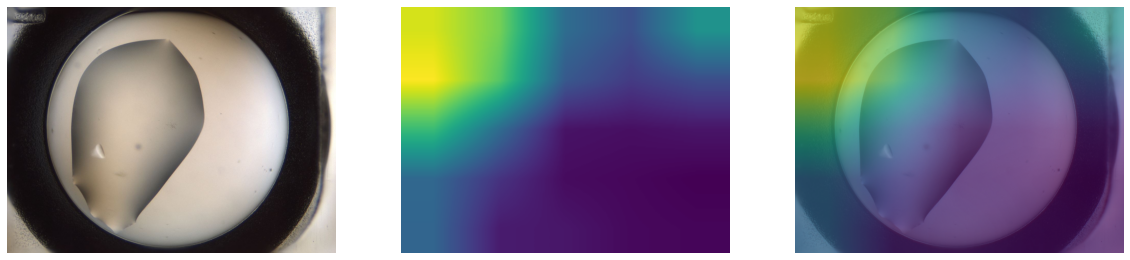

In [35]:
f, ax = plt.subplots(1,3, figsize=(20, 10))

plt.axis('off'); 
ax[0].imshow(orig); 
ax[1].imshow(heatmap_inc); 
ax[2].imshow(output_inc); 
[axi.set_axis_off() for axi in ax.ravel()];